# Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
import scienceplots
scienceplots.stylesheets
plt.style.use('science')

# Overlapping Periodicity

/tmp/ipykernel_1959808/2117854037.py:7: RuntimeWarning: divide by zero encountered in divide
  after = np.floor((1 / LD_ratio - P / 100) / (1 - P / 100))


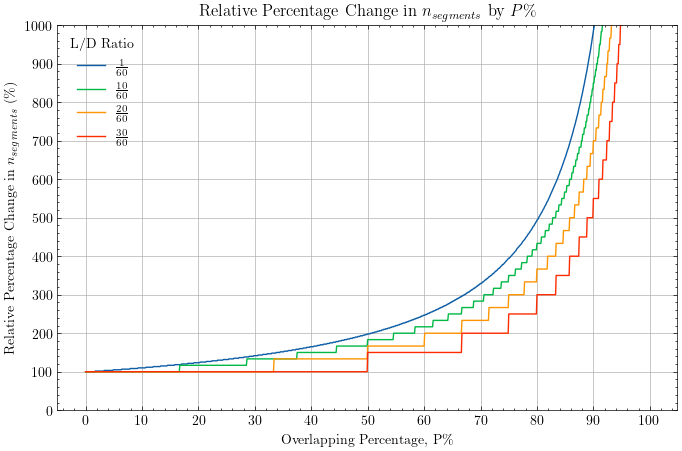

In [3]:
P = np.linspace(0, 100, 1001)

plt.figure(figsize=(8, 5))
for L, D in [(1, 60), (10, 60), (20, 60), (30, 60)]:
    LD_ratio = L / D
    before = np.floor(1 / LD_ratio)
    after = np.floor((1 / LD_ratio - P / 100) / (1 - P / 100))
    relative_diff = after / before * 100
    plt.plot(P, relative_diff, label=f'$\\frac{{{L}}}{{{D}}}$')

plt.title('Relative Percentage Change in $n_{segments}$ by $P\%$')
plt.xlabel('Overlapping Percentage, P\%')
plt.ylabel('Relative Percentage Change in $n_{segments}$ ($\%$)')
plt.ylim(0, 1000)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 1001, 100))
plt.legend(title='L/D Ratio')
plt.grid(True)
# plt.savefig('figures/overlapping_relative_change.png', dpi=300)
plt.show()

# Subject ID Distribution

```
import torch
torch.multiprocessing.set_sharing_strategy('file_system')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from dataset import prepare_dataset, prepare_dataloaders

# Load datasets
datasets = prepare_dataset(feature_type='de_grid', class_type='binary', overlap_percent=0)

dataset_names = ['deap', 'seed', 'dreamer']
seeds = [1, 2, 3, 4, 5]  # List of seeds you want to use

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['dataset', 'seed', 'subset', 'subject_id'])

def extract_info(dataloader, dataset_name, seed, subset):
    data_list = []
    for X, y, subject_ids in dataloader:
        for subject_id in subject_ids:
            # Check if subject_id is a tensor and extract the item if it is
            if isinstance(subject_id, torch.Tensor):
                subject_id = subject_id.item()
            data_list.append({'dataset': dataset_name, 'seed': seed, 'subset': subset, 'subject_id': subject_id})
    return data_list

# Loop through datasets, seeds, and dataloaders to extract information
for seed in seeds:
    print(f"Seed: {seed}")
    for i, dataset_name in enumerate(dataset_names):
        trainloaders, valloaders, testloaders = prepare_dataloaders(datasets, batch_size=64, test_ratio=0.2, seed=seed, with_subject_id=True)
        
        train_data = extract_info(trainloaders[i], dataset_name, seed, 'train')
        val_data = extract_info(valloaders[i], dataset_name, seed, 'val')
        test_data = extract_info(testloaders[i], dataset_name, seed, 'test')
        
        df = pd.concat([df, pd.DataFrame(train_data)], ignore_index=True)
        df = pd.concat([df, pd.DataFrame(val_data)], ignore_index=True)
        df = pd.concat([df, pd.DataFrame(test_data)], ignore_index=True)
        
# Processing the subject_id column

def extract_number(value):
    if isinstance(value, str):
        # Extract the numeric part if the value is a string in 'sxx.dat' format
        match = pd.Series(value).str.extract(r's(\d+).dat')
        if not match.isna().values[0][0]:  # Check if extraction was successful
            return int(match[0][0])
    elif isinstance(value, int):
        # Return the value if it's already an integer
        return value
    return None  # In case the format is unexpected

df['subject_id'] = df['subject_id'].apply(extract_number)
df['dataset'] = df['dataset'].astype('category')
df['seed'] = df['seed'].astype('category')
df['subset'] = df['subset'].astype('category')

df.to_pickle('subject_id_distribution.pkl')
```

In [4]:
# Load the data
df = pd.read_pickle("subject_id_distribution.pkl")

# Group by 'dataset', 'subset', 'seed', 'subject_id' and calculate the size
pivot_data = df.groupby(['dataset', 'subset', 'seed', 'subject_id']).size().reset_index(name='count')

# Filter out rows with count > 0
pivot_data = pivot_data[pivot_data['count'] > 0]

# Convert 'dataset' and 'subset' to categorical with specified order
pivot_data['dataset'] = pivot_data['dataset'].str.upper()
pivot_data['dataset'] = pd.Categorical(pivot_data['dataset'], categories=['DEAP', 'SEED', 'DREAMER'], ordered=True)
pivot_data['subset'] = pivot_data['subset'].replace({
    'train': 'Train set',
    'val': 'Validation set',
    'test': 'Test set'
})
pivot_data['subset'] = pd.Categorical(pivot_data['subset'], categories=['Train set', 'Validation set', 'Test set'], ordered=True)

# Calculate the percentage within each group
pivot_data['percentage'] = pivot_data.groupby(['dataset', 'subset', 'seed'])['count'].transform(lambda x: x / x.sum() * 100)

# Add 1 to subject_id if the dataset is DREAMER
pivot_data.loc[pivot_data['dataset'] == 'DREAMER', 'subject_id'] += 1

# Convert 'subject_id' to string for hue
pivot_data['subject_id'] = pivot_data['subject_id'].astype(str)

pivot_data.head()

,dataset,subset,seed,subject_id,count,percentage
1,DEAP,Test set,1,1,446,2.903646
2,DEAP,Test set,1,2,475,3.092448
3,DEAP,Test set,1,3,499,3.248698
4,DEAP,Test set,1,4,488,3.177083
5,DEAP,Test set,1,5,539,3.509115


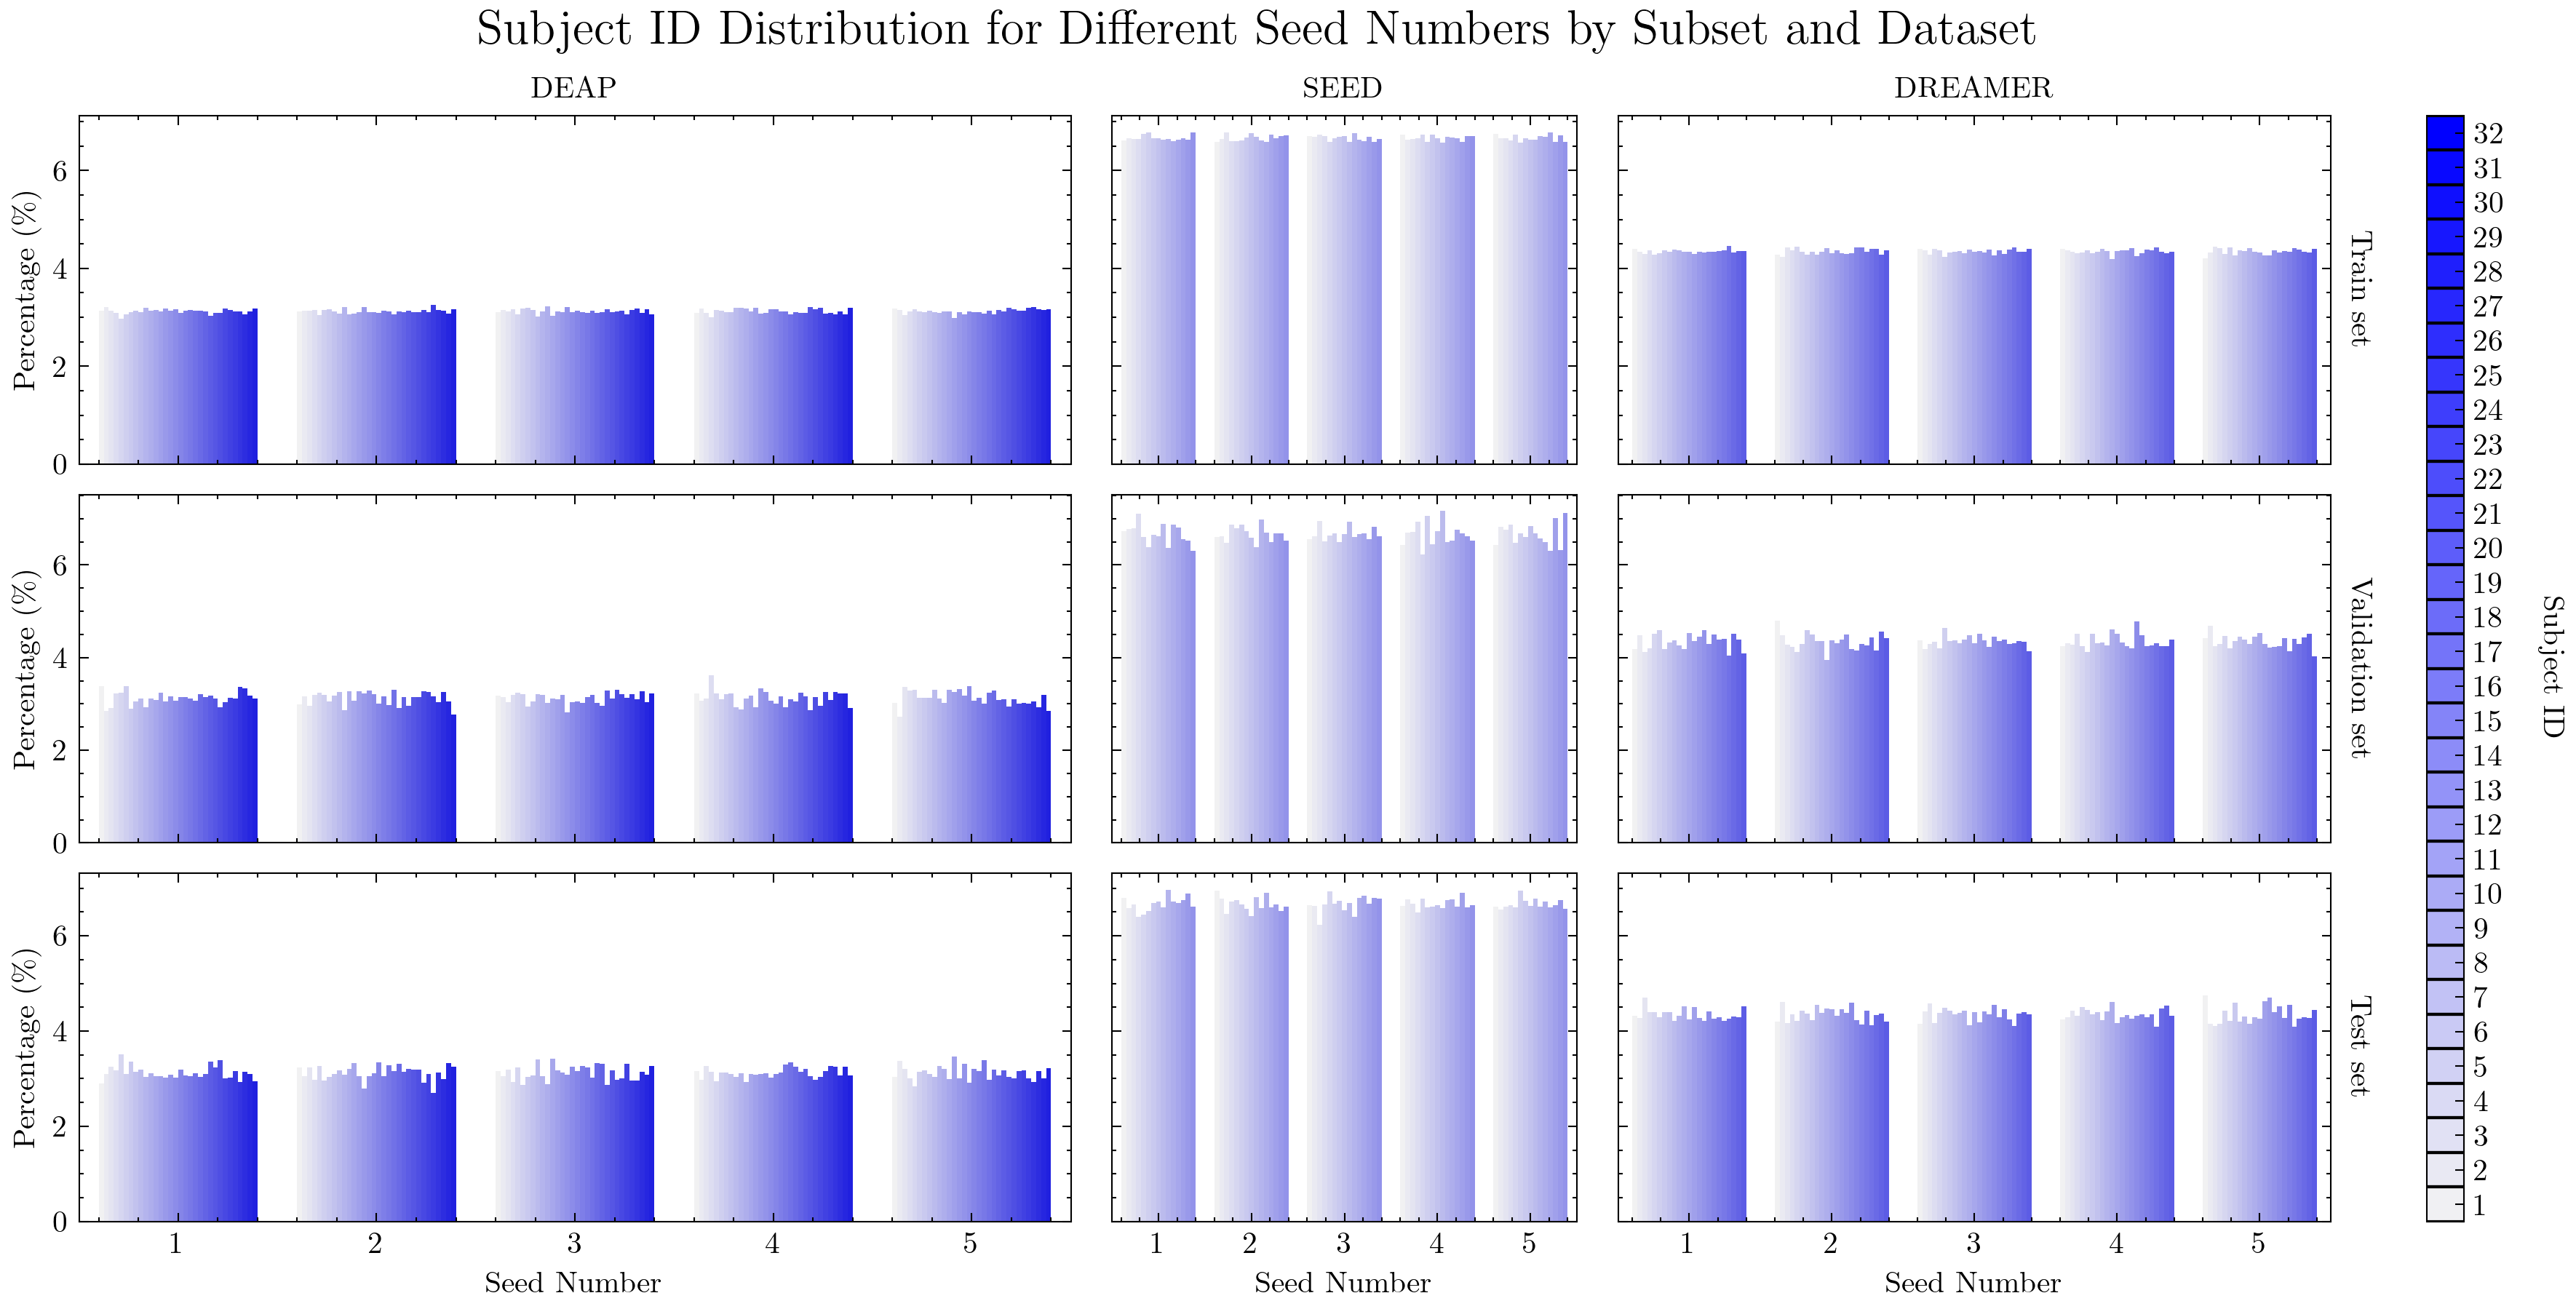

In [5]:
# Create a color palette for subject_id
unique_subject_ids = pivot_data['subject_id'].unique()
palette = sns.color_palette("light:blue", len(unique_subject_ids))
color_mapping = {subject_id: palette[i] for i, subject_id in enumerate(unique_subject_ids)}

# Create the FacetGrid
g = sns.FacetGrid(pivot_data, row='subset', col='dataset', margin_titles=True, despine=False, sharex='col', sharey='row', gridspec_kws=dict(width_ratios=[32, 15, 23]))

# Draw bar plots with the custom color palette
g.map_dataframe(sns.barplot, x='seed', y='percentage', hue='subject_id', palette=color_mapping, errorbar=None)

# Set the figure size and DPI
g.fig.set_size_inches(12, 6)
g.fig.set_dpi(300)

# Add titles and adjust the position
g.fig.subplots_adjust(top=0.9)  # Adjust 'left' to make space for row titles and 'right' to make space for the legend
g.fig.suptitle('Subject ID Distribution for Different Seed Numbers by Subset and Dataset', fontsize=16)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Set x-axis and y-axis labels
for ax in g.axes.flat:
    ax.set_xlabel("Seed Number")
    ax.set_ylabel("Percentage (\%)")

# Create a discrete colorbar with black borders
cmap = ListedColormap(palette)
bounds = np.arange(len(unique_subject_ids) + 1)
norm = BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
cbar = g.fig.colorbar(sm, ax=g.axes, orientation='vertical', fraction=0.02, pad=0.04, aspect=30, ticks=np.arange(len(unique_subject_ids)))
cbar.set_label('Subject ID', rotation=270, labelpad=20)  # Rotate the label to 270 degrees
cbar.set_ticks(np.arange(len(unique_subject_ids)))
cbar.set_ticklabels(unique_subject_ids)

# Manually set tick positions to be centered
tick_positions = np.arange(len(unique_subject_ids)) + 0.5
cbar.ax.set_yticks(tick_positions)
cbar.ax.set_yticklabels(unique_subject_ids)

# Draw black borders around each segment
cbar_ax = cbar.ax
for j in range(len(unique_subject_ids)):
    cbar_ax.hlines([j, j + 1], 0, 1, colors='black')

# Show the plot
# plt.savefig("figures/subject_id_distribution.png", bbox_inches='tight')
plt.show()

In [6]:
# if uniform distribution
print("DEAP:", 100/32)
print("SEED:", 100/15)
print("DREAMER:", 100/23)

DEAP: 3.125
SEED: 6.666666666666667
DREAMER: 4.3478260869565215


# Softmax with Temperature

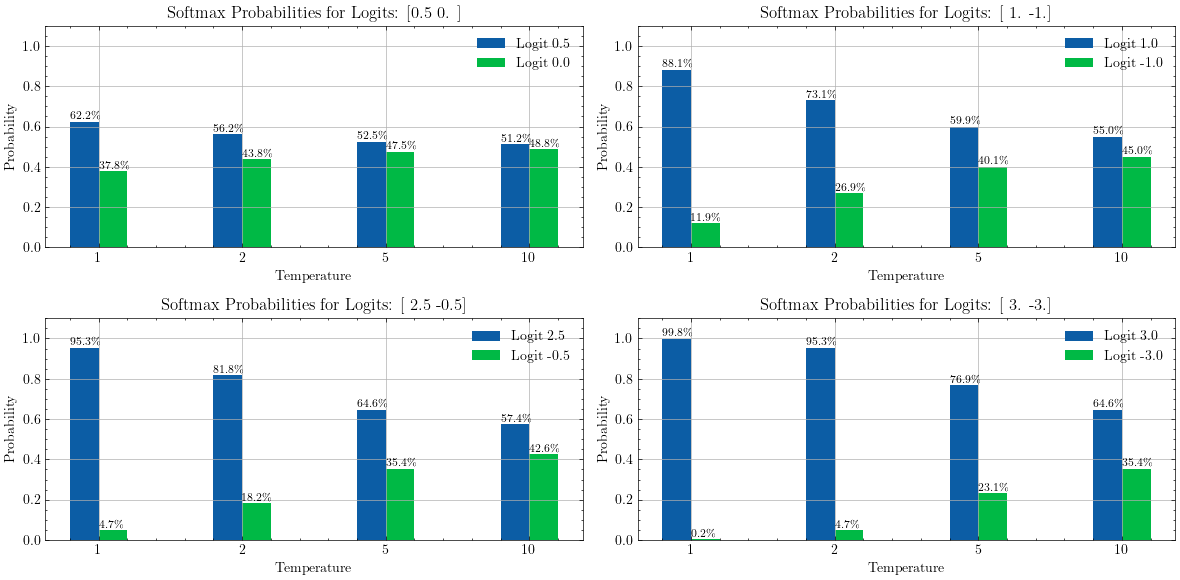

In [7]:
# Define the softmax function with temperature using PyTorch
def softmax_with_temperature(logits, temperature):
    logits_tensor = torch.tensor(logits / temperature)
    return F.softmax(logits_tensor, dim=0).numpy()

# Define different sets of logits for binary classification
logit_sets = [
    np.array([0.5, 0.0]),    # Example logits set 1
    np.array([1.0, -1.0]),     # Example logits set 2
    np.array([2.5, -0.5]),    # Example logits set 3
    np.array([3.0, -3.0])     # Example logits set 4
]

# Define the temperatures to test
temperatures = [1, 2, 5, 10]

# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Calculate and plot softmax probabilities for each set of logits and each temperature
for i, logits in enumerate(logit_sets):
    ax = axes[i]
    width = 0.2  # width of the bars
    x = np.arange(len(temperatures))  # label locations

    for j, logit in enumerate(logits):
        probabilities = [softmax_with_temperature(logits, T)[j] for T in temperatures]
        bars = ax.bar(x + j * width, probabilities, width, label=f'Logit {logit}')
        
        # Set y-axis limit
        ax.set_ylim(0, 1.1)
        
        # Add text at the top of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x(), yval, f'{100*yval:.1f}\%', ha='left', va='bottom', fontsize=8)

    # Add labels and title
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Probability')
    ax.set_title(f'Softmax Probabilities for Logits: {logits}')
    ax.set_xticks(x + width * (len(logits) - 1) / 2)
    ax.set_xticklabels([f'{T}' for T in temperatures])
    ax.legend()
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("figures/softmax_temperature_binary.png", bbox_inches='tight')
plt.show()

# Differential Entropy

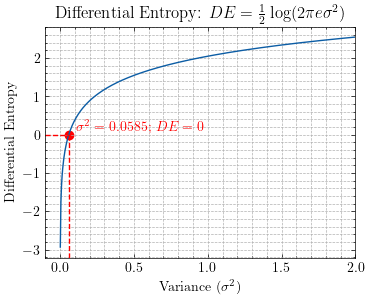

In [8]:
# Define the differential entropy function
def differential_entropy(var):
    return 1 / 2 * np.log2(2 * np.pi * np.e * var)

# Calculate the value of var that causes DE(X) to be 0
var_zero_de = 1 / (2 * np.pi * np.e)

# Define a range of variance values, avoiding zero and handling large values with log scale
variance_values = np.linspace(0.001, 2, 500)  # From a small positive number to 1

# Calculate the differential entropy for each variance value
entropy_values = differential_entropy(variance_values)

# Create the plot
plt.figure(figsize=(4, 3))
plt.plot(variance_values, entropy_values, label='DE(X)')
plt.xlabel('Variance $(\sigma^2)$')
plt.ylabel('Differential Entropy')
plt.title(r'Differential Entropy: $DE = \frac{1}{2}\log(2\pi e \sigma^2)$')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(-0.1, 2)

# Add info
plt.scatter([var_zero_de], [0], color='red')
plt.text(var_zero_de+0.05, 0.1, f'$\sigma^2 = {var_zero_de:.4f}$; $DE = 0$', color='red', ha='left')
plt.axvline(var_zero_de, color='red', linestyle='--', ymin=0, ymax=0.525)
plt.axhline(0, color='red', linestyle='--', xmin=0, xmax=0.08)

# plt.savefig(f"figures/differential_entropy.png", dpi=300)

plt.show()